# Fake News Detection com FakeBERT (BERT + CNN)

In [10]:
import pandas as pd
from sklearn.utils import shuffle
import re

# Carregar os datasets
df_fake = pd.read_csv("Data/Fake.csv")
df_true = pd.read_csv("Data/True.csv")

# Adicionar rótulo: 0 = fake, 1 = true
df_fake['label'] = 0
df_true['label'] = 1

def limpar_prefixo_agencia(texto):
    return re.sub(r"^(.*?\(Reuters\)[\s\-–]*)", "", texto)

df_true['text'] = df_true['text'].apply(limpar_prefixo_agencia)

# Juntar os dados
df = pd.concat([df_fake, df_true], ignore_index=True)
df = shuffle(df).reset_index(drop=True)

# Remover textos duplicados antes da divisão
df = df.drop_duplicates(subset='text').reset_index(drop=True)

# Verificar estrutura
df[['title', 'text', 'label']].head()


,title,text,label
0,Ted Cruz Reveals Paranoid Fantasy Involving O...,Republican presidential hopeful Ted Cruz stunn...,0
1,GOP MAJORITY SENATE FINALLY GETS IT RIGHT: Vot...,The Democrats tried to attach a gun control am...,0
2,"Rejecting Trump, Wall Street Republican donors...",Largely united in their dislike of Republican ...,1
3,COLLEGE PROFESSOR CAUGHT ON TAPE: You Can’t Ha...,Close your eyes and imagine a white professor ...,0
4,Spanish foreign minister calls Catalonia's lea...,The independence speech made by Catalonia s le...,1


In [11]:
# Dividir em treino, validação e teste
from sklearn.model_selection import train_test_split

train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    df['text'], df['label'], test_size=0.2, stratify=df['label'], random_state=42)

val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)


In [12]:
# Tokenização com BERT
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize_data(texts):
    return tokenizer(
        list(texts),
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors='pt'
    )

train_encodings = tokenize_data(train_texts)
val_encodings = tokenize_data(val_texts)
test_encodings = tokenize_data(test_texts)

In [13]:
import torch
from torch.utils.data import Dataset

class FakeNewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels.reset_index(drop=True)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float)
        return item

# Criar datasets
train_dataset = FakeNewsDataset(train_encodings, train_labels)
val_dataset = FakeNewsDataset(val_encodings, val_labels)
test_dataset = FakeNewsDataset(test_encodings, test_labels)

In [ ]:
import torch.nn as nn
from transformers import BertModel

class FakeBERT_CNN(nn.Module):
    def __init__(self):
        super(FakeBERT_CNN, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.conv1 = nn.Conv1d(in_channels=768, out_channels=64, kernel_size=5, padding=1)
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(64, 1)
        self.dropout = nn.Dropout(0.1)

    def forward(self, input_ids, attention_mask):
        bert_out = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state 
        x = bert_out.permute(0, 2, 1)  
        x = torch.relu(self.conv1(x))  
        x = self.pool(x).squeeze(2)    
        x = self.dropout(x)
        logits = self.fc(x).squeeze(1)  
        return logits

In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeBERT_CNN().to(device)

from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()


In [16]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, recall_score, confusion_matrix 
from tqdm import tqdm

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for batch in tqdm(loader, desc="Treino"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(loader)

In [17]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    preds, true_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Validação"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = torch.sigmoid(outputs)
            preds.extend(probs.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    preds_bin = [1 if p >= 0.5 else 0 for p in preds]
    acc = accuracy_score(true_labels, preds_bin)
    f1 = f1_score(true_labels, preds_bin)
    roc = roc_auc_score(true_labels, preds)
    precision = precision_score(true_labels, preds_bin)
    recall = recall_score(true_labels, preds_bin)

    return total_loss / len(loader), acc, f1, roc, precision, recall, preds_bin, true_labels


In [18]:
EPOCHS = 3

for epoch in range(EPOCHS):
    print(f"\nÉpoca {epoch+1}/{EPOCHS}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, acc, f1, roc, precision, recall, _, _ = evaluate(model, val_loader, criterion, device)

    print(f"\n Val Loss: {val_loss:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC AUC: {roc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")



Época 1/3


Validação: 100%|██████████| 242/242 [00:50<00:00,  4.81it/s]



 Val Loss: 0.0113 | Accuracy: 0.9961 | F1: 0.9965 | ROC AUC: 1.0000 | Precision: 0.9962 | Recall: 0.9967

Época 2/3


Validação: 100%|██████████| 242/242 [00:50<00:00,  4.81it/s]



 Val Loss: 0.0166 | Accuracy: 0.9935 | F1: 0.9941 | ROC AUC: 0.9999 | Precision: 0.9990 | Recall: 0.9892

Época 3/3


Validação: 100%|██████████| 242/242 [00:50<00:00,  4.81it/s]


 Val Loss: 0.0069 | Accuracy: 0.9990 | F1: 0.9991 | ROC AUC: 1.0000 | Precision: 0.9981 | Recall: 1.0000


In [19]:
test_loader = DataLoader(test_dataset, batch_size=16)

val_loss, acc, f1, roc, precision, recall, preds, labels = evaluate(
    model, test_loader, criterion, device)

print(f"\n Val Loss: {val_loss:.4f} | Accuracy: {acc:.4f} | F1: {f1:.4f} | ROC AUC: {roc:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")


Validação: 100%|██████████| 242/242 [00:50<00:00,  4.80it/s]


 Val Loss: 0.0027 | Accuracy: 0.9992 | F1: 0.9993 | ROC AUC: 1.0000 | Precision: 0.9991 | Recall: 0.9995


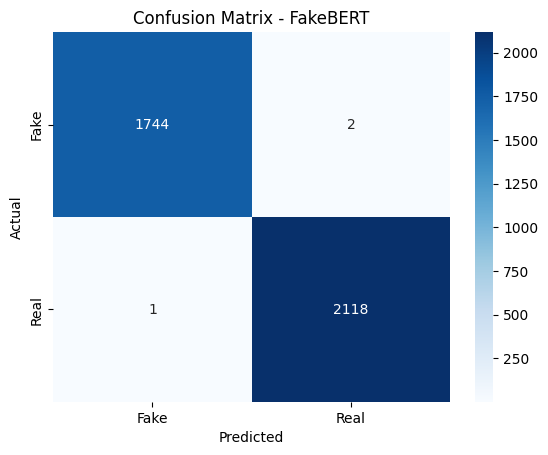

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - FakeBERT')
plt.show()